# Exercise session 13: Learning in Artificial Neural Networks (ANNs) vs. learning in Spiking Neural Networks (SNNs)

Welcome to the thirteenth (and final!) exercise session of the intro to neuroinformatics course. In this notebook, we will investigate some of the differences between ANNs and SNNs. Admittedly, we chose a task that is rather well suited for ANNs and then train an SNN on the same data.
By doing so, we cannot really explore all the benefits of SNNs. However, we will show that SNNs have similar capabilities to ANNs - which is quite impressive!


---

# Table of contents

* [Packages](#packages)
* [Introduction](#0)
* [1: The yin yang dataset](#1)
  * [1.1: Creating the dataset and loading with PyTorch](#1.1)
  * [1.2: Inspecting a sample from the yin yang dataset](#1.2)
* [2: Defining the artificial neural network (ANN)](#2)
  * [2.1: Components of the artificial neural network](#2.1)
  * [2.2: Mathematical overview](#2.2)
  * [2.3: Configurations](#2.3)
    * [2.3.1: Linear classifier (reference model)](#2.3.1)
    * [2.3.2: Frozen input layer (feature freezing)](#2.3.2)
    * [2.3.3: ANN with one hidden layer (120 neurons)](#2.3.3)
* [3: Training procedure of the artificial neural network](#3)
  * [3.1: Loss function: Cross-entropy loss](#3.1)
  * [3.2: Optimizer: AdamW](#3.2)
  * [3.3: Learning rate scheduler: ReduceLROnPlateau](#3.3)
  * [3.4: Training epochs](#3.4)
  * [3.5: Validation and testing](#3.5)
* [4: Training the linear model](#4)
  * [4.1: Training the model with frozen layer](#4.1)
  * [4.2: Training the model with hidden layer](#4.2)
* [5: Spiking neural networks (SNNs)](#5)
  * [5.1: Input preparation](#5.1)
  * [5.2: Plot a data sample](#5.2)
  * [5.3: Mathematical model](#5.3)
  * [5.4: Training the spiking neural network](#5.4)
  * [5.5: Surrogate gradient descent](#5.5)
  ---

# Packages <a name="packages"></a>

First, we need to update the widgets since we use a never version than the Colab default. We also import some files that we use later on.

In [23]:
!pip install -U ipywidgets

In [24]:
!mkdir utils_ex13
!wget -P utils_ex13/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/ann.py
!wget -P utils_ex13/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/ann_data.py
!wget -P utils_ex13/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/snn.py
!wget -P utils_ex13/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/snn_data.py

mkdir: cannot create directory ‘utils_ex13’: File exists
--2025-12-10 20:38:16--  https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/ann.py
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/utils_ex13/ann.py [following]
--2025-12-10 20:38:16--  https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/utils_ex13/ann.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4938 (4.8K) [text/plain]
Saving to: ‘utils_ex13/ann.py.1’

ann.py.1            100%[===================>]   4.82K  --.-KB/s    in 0s   

In [25]:
from utils_ex13.ann import *
from utils_ex13.ann_data import *

---

# Introduction <a name="0"></a>

In this exercise, we will explore differences between **Artificial Neural Networks (ANNs)** and **Spiking Neural Networks (SNNs)**. Neural networks have become an essential tool in modern machine learning and artificial intelligence. While ANNs have been the standard for many years, SNNs, inspired by biological neurons' behavior, present a more biologically plausible approach to computation and learning and consume much less power on corresponding hardware.

## Questions to Consider

- How do the mechanisms of learning differ between ANNs and SNNs?
- What are the key advantages and disadvantages of ANNs over SNNs, and vice versa?
- How does the training time and computational complexity compare between the two models?
- How do the network architectures (feedforward vs. spiking) affect their ability to generalize on the Ying Yang dataset?

Let's get started by defining the dataset first.

---


# 1: The Yin Yang Dataset <a name="1"></a>

The **Yin Yang dataset** is a synthetic dataset. It is inspired by the concept of the **Yin and Yang**, a symbol from Chinese philosophy that represents the duality of opposites in harmony. The symbol itself consists of two interlocking shapes, one dark and one light, that are complementary yet distinct, reflecting the balance between opposing forces.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Yin_yang.svg/800px-Yin_yang.svg.png"  width="300">

In the context of this dataset, the **Yin Yang symbol** is represented by three distinct classes:

1. **The Yin**: This class represents the darker part of the symbol. Points belonging to this class are corresponding to the dark side of the Yin Yang symbol.
  
2. **The Yang**: The lighter counterpart of the Yin class. Points in this class are corresponding to the light side of the symbol.
  
3. **The Two Circles**: Points in this class are corresponding to the two inner circles.

As shown in the image, the three classes are not eperable by linear decision boundaries. Thus, we need something more complex than a linear classifier to classify the points correctly.

## Features

The dataset consists of many data points, each represented by two coordinates: **x** and **y**. These coordinates are confined within the range **0 to 1** for both axes. Based on the values of **x** and **y**, each data point is assigned to one of the three classes.

In the upcoming sections, we will use this dataset to train both an **Artificial Neural Network (ANN)** and a **Spiking Neural Network (SNN)** to explore the differences in how these models learn and classify the data.

---


# 1.1: Creating the Dataset and Loading with PyTorch <a name="1.1"></a>

We do not ask you to look at the implementation. However, you should understand the differences between a dataset and a dataloader. For details, please refer to the PyTorch documentation.

- https://pytorch.org/docs/stable/data.html
- https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
- https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

To train our models on the Ying Yang dataset, we first create a custom PyTorch dataset using the `torch.utils.data.Dataset` class. This class allows us to represent our dataset by storing all samples, define data features ($x,y$ coordinates), and customize the data preprocessing if needed. We then wrap this dataset into a PyTorch **DataLoader**, which is an efficient tool for batching, shuffling, and loading data during training.

##### PyTorch Dataset Instance

We start by defining the Ying Yang dataset as a PyTorch dataset. The dataset consists of a set of data points, each with an associated **x** and **y** coordinate (in the range 0 to 1). Depending on the coordinates, each data point is assigned to one of the three classes: **Yin**, **Yang**, or **Two Circles**.

Once we have the dataset instance, we split the dataset into **training**, **validation**, and **test** sets to ensure a good evaluation of the model's performance.

##### PyTorch DataLoader

After defining the dataset, we wrap it in a PyTorch **DataLoader**. The DataLoader is a powerful utility that helps us:

- **Batch the data**: It splits the dataset into smaller batches, so we don’t have to load the entire dataset at once, which helps save memory and speeds up training.
- **Shuffle the data**: It randomizes the data each time it is loaded, preventing the model from learning patterns based on the order of the data.
- **Parallelize data loading**: The DataLoader can load data in parallel using multiple workers, which improves efficiency when training large models.

Below, we have plotted the dataset with points belonging to each of the three classes:


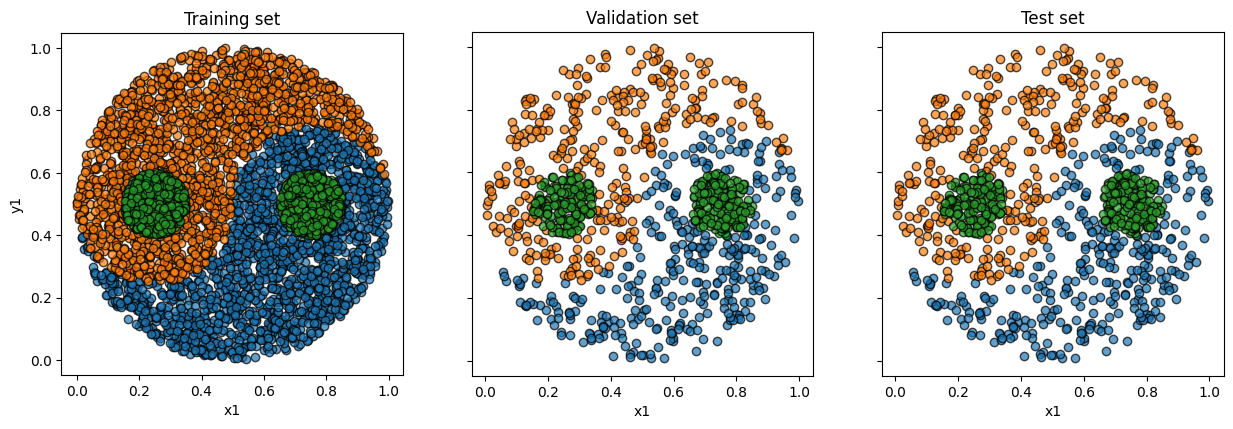

In [26]:
train_loader, val_loader, test_loader = get_dataloader()
plot_data(train_loader, val_loader, test_loader)


---

> **Assignment 1**
>
> What is the purpose of using training, validation, and test sets?
>
> <details>
>
> <summary>Solution</summary>
>
> The purpose of using **training**, **validation**, and **test sets** is to ensure that our model generalizes well to new, unseen data. The **training set** is used to train the model, adjusting weights and learning the relationships in the data. The **validation set** is used during training to tune hyperparameters (such as learning rate, batch size, etc.) and to detect overfitting by evaluating the model on data that is not part of the training set. Finally, the **test set** is used after training to assess the model's final performance on data that it has never seen before, providing an unbiased estimate of the model's ability to generalize.



> **Assignment 2**
>
> Why use DataLoader and not directly the dataset?
>
> <details>
>
> <summary>Solution</summary>
>
> The **DataLoader** provides several key advantages over using the dataset directly:
>  1. **Batching**: The DataLoader automatically divides the dataset into batches, which helps with memory management and can speed up training by allowing the model to process multiple data points simultaneously.
>  2. **Shuffling**: It randomly shuffles the data at the beginning of each epoch, ensuring that the model doesn’t learn patterns from the order of the data, which could lead to overfitting.
>  3. **Parallel data loading**: DataLoader can use multiple workers to load data in parallel, which can speed up training, especially when dealing with large datasets.
>  4. **Efficient iteration**: DataLoader allows you to iterate through the dataset in a more efficient way, handling batch sizes, shuffling, and other features automatically.

---



# 1.2: Inspecting a Sample from the Ying Yang Dataset <a name="1.2"></a>

Now that we have wrapped our dataset in a **DataLoader**, we can inspect individual samples. To view one sample, we can print it by accessing it directly from the dataset using the index `i`:

```python
sample = train_loader.dataset[i]
print(sample)
```

An example of the output might look like this:

```
(array([0.68030754, 0.45049925, 0.31969246, 0.54950075]), 2)
```

This output consists of two parts:
1. The **first part** is an array of four values:
    - The first two numbers represent the **x** and **y** coordinates of the data point in the 2D space.
    - The next two values are **1 - x** and **1 - y**, which are transformations of the original coordinates, reflecting the inverse of the respective axis. These transformations provides a bit more information to the networks we will train below.

2. The **second part** is the **class label** of the sample, which can be one of the three classes: **Yin (0)**, **Yang (1)**, or **Two Circles (2)**.

---





> **Assignment 3**
>
> - **Choose a random sample** by setting the index `i` to a random value.
> - **Print the sample** and think about where this sample should appear on the plot:
>   - Where would the sample be located in the plot based on the **x** and **y** coordinates?
>   - Based on the class label (the second part of the print output), what color should the point have?
>     - **Yin (0)**: Black
>     - **Yang (1)**: White
>     - **Two Circles (2)**: Gray
>
> **Hint:** After printing the sample, you can use the `plot_ying_yang_data` function below to plot the sample and visualize its position and color.
---

In [27]:
i = 0
sample = train_loader.dataset[i]
print(sample)

(array([0.68030754, 0.45049925, 0.31969246, 0.54950075]), 2)


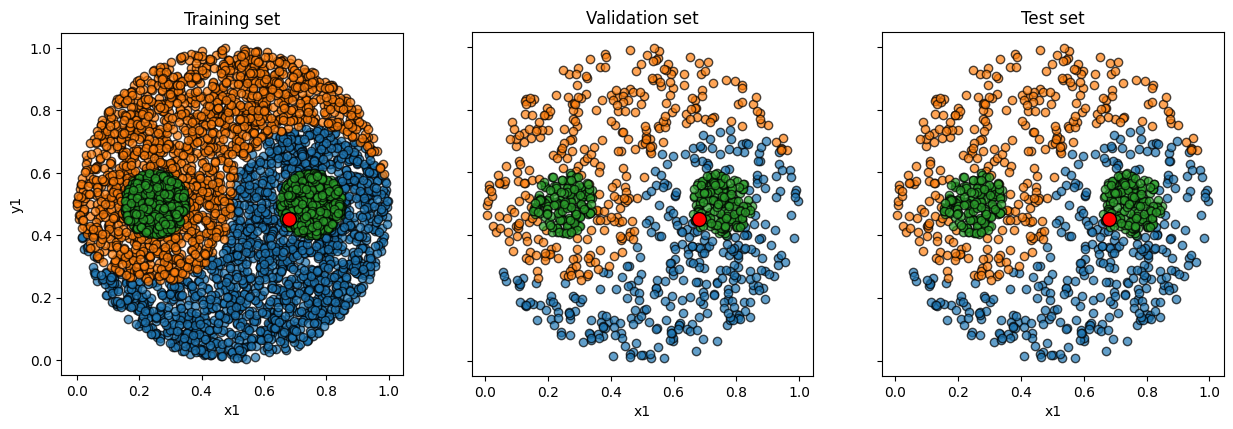

In [28]:
plot_data(train_loader, val_loader, test_loader, highlight=sample)

---

# 2: Defining the Artificial Neural Network (ANN) <a name="2"></a>

In this section, we will define the architecture of the **Artificial Neural Network (ANN)** that we will use to train on the Ying Yang dataset. Our ANN will consist of one or more **linear layers** (also known as fully connected layers), with **ReLU (Rectified Linear Unit)** activation functions applied after each layer except the last one.

---




## 2.1: Components of the Artificial Neural Network <a name="2.1"></a>

1. **Linear Layers**: A **linear layer** (also called a fully connected layer) is a basic building block of an ANN. In this layer, each neuron is connected to every neuron in the previous layer. Mathematically, a linear layer computes a weighted sum of its inputs and adds a **bias term**:

   $$
   y = W \cdot x + b
   $$

   Where:
   - $x$ is the input vector to the layer (from the previous layer or input data),
   - $W$ is the weight matrix, which holds the learnable parameters that define the strength of the connections between neurons,
   - $b$ is the **bias vector**, an additional learnable parameter that allows the model to shift the activation of neurons,
   - $y$ is the output of the linear transformation.

   In a neural network, we update $W$ and $b$ during training to minimize the error between the predicted output and the target values.

2. **ReLU Activation Function**: After each linear layer, except for the last one, we apply a **ReLU activation function**. The ReLU function is defined as:

   $$
   \text{ReLU}(x) = \max(0, x)
   $$

   This function introduces **non-linearity** into the model, allowing the neural network to learn more complex patterns. ReLU ensures that only positive values pass through, while negative values are set to zero. This helps in training the network by preventing negative activations and enabling sparse activations.

   The ReLU activation allows the network to learn complex relationships that linear models cannot.

3. **Output Layer**: The final layer does not have any activation function. It produces the **raw outputs** (often called **logits**) of the network, which represent the final predictions for each class. These raw values can later be passed through a **softmax** function to obtain a "probability" per class.

   The output layer will have as many neurons as the number of classes. In our case, we will have **three neurons** corresponding to the three classes (Yin, Yang, and Two Circles).

4. **Bias Term**: The **bias** term $b$ allows the network to make adjustments to the output, helping the model fit the data better. Without the bias term, all neurons in the same layer would have to pass through the origin, which would limit the expressiveness of the model. The bias term provides a way for neurons to have an output even when all the inputs are zero.

---



## 2.2: Mathematical Overview <a name="2.2"></a>

If we have an input vector $x$ of size $n$, a linear layer with weights $W$ of size $m \times n$, and a bias vector $b$ of size $m$, then output $y$ is of size $m$ and is calculated as:

$$
\text{ReLU}(y) = \text{ReLU}(W \cdot x + b) = \max(0, W \cdot x + b)
$$

In summary, our artificial neural network consists of:

- **One or more linear layers** that calculate a weighted sum of inputs plus a bias term.
- **ReLU activation functions** applied after each linear layer, except for the last one.
- The **final output** is the raw value of the last layer’s neurons (the logits), which represent the predicted class scores. We apply a Softmax function to these scores to obtain the final class probabilities.

---

## 2.3: Configurations <a name="2.3"></a>

We will use different network configurations to train the Artificial Neural Network (ANN) on the Ying Yang dataset. Each configuration specifies the layout of the neural network, including the number of layers, the number of neurons in each layer, and other settings such as whether the first layer is frozen.

---


### 2.3.1: Linear Classifier (Reference Model) <a name="2.3.1"></a>


<img src="https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/figures/net_1.png"  width="250">


```python
shallow_network_layout = {
    'n_inputs': 4,
    'layer_sizes': [3],
}
linear_classifier = ANN(shallow_network_layout)
```

- **n_inputs**: This specifies the number of input features the network will receive. In this case, the input has 4 features: **x**, **y**, **1-x**, and **1-y**. These features are used as the input for the network.
  
- **layer_sizes**: This list specifies the number of neurons in each layer. In this case, there are **no hidden layers**. Instead, the network directly maps the 4 input features to 3 output neurons. This means the network is essentially a **linear classifier** with a single layer that performs a direct mapping from input to output.

  - **Input layer**: 4 input neurons (corresponding to the 4 features).
  - **Output layer**: 3 neurons (representing the 3 possible classes: Yin, Yang, and Two Circles).
  
This configuration is a **simple linear model** where no intermediate computations are made between the input and output.

---


### 2.3.2: Frozen Input Layer (Feature Freezing) <a name="2.3.2"></a>

<img src="https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/figures/net_2.png"  width="400">

```python
shallow_network_layout = {
    'n_inputs': 4,
    'layer_sizes': [30, 3],
}
ann_frozen = ANN(shallow_network_layout, freeze_first_layer=True)
```

- **n_inputs**: The number of input features remains the same at 4, corresponding to **x**, **y**, **1-x**, and **1-y**.

- **layer_sizes**: This network has two layers:
  - **First hidden layer** with **30 neurons**.
  - **Output layer** with **3 neurons** (again corresponding to the three classes: Yin, Yang, and Two Circles).

- **freeze_first_layer=True**: This setting means that the **connections from the input to the first hidden layer** will be "frozen" during training. In other words, the weights and biases of this layer will **not be updated** by the backpropagation algorithm during training. Only the second layer (the output layer) will have its weights and biases adjusted to minimize the error.

Usually, freezing the first layer(s) is useful when we want to preserve the learned features of that layer (e.g., if it has already been pre-trained or if we want to reduce the number of parameters to be optimized). This allows the network to focus on learning the mapping from the first hidden layer to the output layer, rather than adjusting the first layer's weights. However, in this lab, we did not pre-train the first layer. Instead, the the weights are initialized randomly and not allowed to change. You can interpret this as a mapping of the initial features with $4$ dimensions to a higher-dimensional space with $30$ dimensions, which is then used to classify the data.

---



### 2.3.3: ANN with One Hidden Layer (120 Neurons) <a name="2.3.3"></a>

<img src="https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/figures/net_3.png"  width="400">

```python
network_layout = {
    'n_inputs': 4,
    'layer_sizes': [30, 3],
}
net = ANN(network_layout)
```

- **n_inputs**: As with the previous networks, this configuration also uses 4 input features: **x**, **y**, **1-x**, and **1-y**.

- **layer_sizes**: This network has two layers:
  - **First hidden layer** with **30 neurons**.
  - **Output layer** with **3 neurons** (representing the 3 classes: Yin, Yang, and Two Circles).

- In this case, **both layers are trainable**, meaning the weights and biases of both the first hidden layer and the output layer will be updated during training.

This configuration is a standard feed-forward neural network with a hidden layer, allowing the network to learn non-linear relationships between the input and output.

In [29]:
# Linear classifier for reference
shallow_network_layout = {
    'n_inputs': 4,
    'layer_sizes': [3],
}
linear_classifier = ANN(shallow_network_layout)

# frozen input layer
shallow_network_layout = {
    'n_inputs': 4,
    'layer_sizes': [30, 3],
}
ann_frozen = ANN(shallow_network_layout, freeze_first_layer=True)

# ANN with one hidden layer (with 120 neurons)
network_layout = {
    'n_inputs': 4,
    'layer_sizes': [30, 3],
}
net = ANN(network_layout)

---

> **Assignment 4**
>
> Why is the size of the last layer always 3 in the given configurations? Would other sizes work? **Hint:** Think about the number of classes we are trying to classify.
>
> <details>
>
> <summary>Solution</summary>
>
> The size of the last layer is always 3 because the problem we are trying to solve is a **multi-class classification** problem with **3 classes**: Yin, Yang, and Two Circles. Each neuron in the output layer corresponds to one class. The network needs to output a value for each class to make predictions, and thus, the number of neurons in the last layer must match the number of classes.
>
> Other sizes for the last layer, such as 2 or 5, would **not work** for this task, because the number of output neurons should match the number of classes. If there were 2 neurons, it would imply a 2-class (binary) classification problem, and with 5 neurons, the network would try to classify into 5 classes, which does not match our problem setup.



> **Assignment 5**
>
> What would you expect when having more layers or more neurons? What would happen with the loss and accuracy on the training, validation, and test set?
>
> **Hint:** Think about model complexity and the risk of overfitting.
>
> <details>
>
> <summary>Solution</summary>
>
> Increasing the number of layers or neurons generally increases the **capacity** of the model, meaning the network can learn more complex patterns and relationships in the data. However, this can also lead to **overfitting** if the model becomes too complex for the given data.
>
> - **Training loss:** With more layers or neurons, the model may have an easier time fitting the training data, and the training loss would likely decrease.
>
> - **Validation and test accuracy:** If the model overfits the training data, the validation and test accuracy might improve initially but then start to degrade, because the model may learn to memorize the training data instead of generalizing to unseen examples. The result is a lower performance on the validation and test sets, as the model becomes too specialized.
>
> In general, adding more complexity (i.e., more neurons or layers) can lead to **better performance on the training set**, but this may not translate to better performance on the validation or test sets, where generalization is key. (Note: in this lab, we do not have any noise in the data and therefore we likely do not see overfitting even when using many layers and neurons.)




> **Assignment 6**
>
> Given the three model configurations (linear classifier, frozen input layer, and ANN with one hidden layer), which one do you expect to classify the Ying Yang dataset most effectively? **Hint:** Consider the simplicity of the dataset and the number of layers and neurons.
>
> <details>
>
> <summary>Solution</summary>
>
> The **ANN with one hidden layer** (with 30 neurons) is likely to classify the Ying Yang dataset most effectively. Here's why:
>
> - The **linear classifier** is a very simple model and can only create linear decision boundaries. Therefore, it cannot capture the non-linear patterns inherent in the Yin Yang dataset, which involves a circular, non-linear decision boundary.
> - The **frozen input layer model** can learn some representations but is limited by freezing the first layer, which restricts the learning capacity of the network.
> - The **ANN with one hidden layer** is the most flexible. With 30 neurons in the hidden layer, it can learn complex, non-linear relationships between the inputs (the x, y, 1-x, 1-y coordinates) and the classes (Yin, Yang, and Two Circles). This model has the most potential to generalize well on the Ying Yang dataset, making it the most likely to perform well.




> **Assignment 7**
>
> This is a very simple, basic ANN. What other types of layers do you know? What would be their influence on the network?
>
> <details>
>
> <summary>Solution</summary>
>
> In addition to the basic fully connected (linear) layers, there are several other types of layers used in neural networks, each with its own purpose:
>
> 1. **Convolutional Layers (Conv)**: These layers are commonly used in Convolutional Neural Networks (CNNs) and are designed to process **grid-like data**, such as images. Convolutional layers apply a filter (kernel) over the input, which helps the network learn spatial hierarchies of features. This layer is especially useful for problems like image classification or object detection.
>
>    - **Influence:** Convolutional layers allow the network to learn spatial features and patterns, like edges, textures, and shapes, in a more efficient way than fully connected layers. They reduce the number of parameters and help capture local correlations in the data.
>
> 2. **Recurrent Layers (RNN, LSTM, GRU)**: These layers are used in **Recurrent Neural Networks (RNNs)**, which are designed to handle **sequential data** such as time series, speech, or text. Recurrent layers can "remember" previous inputs in the sequence and use this memory to influence future predictions.
>
>    - **Influence:** Recurrent layers are particularly useful for tasks where the order of the data matters, such as in natural language processing or time series prediction. They can capture temporal dependencies and relationships in data.
>
> 3. **Dropout Layers**: Dropout is a regularization technique where random neurons are "dropped out" during training, meaning their connections are temporarily removed. This prevents the model from relying too heavily on specific neurons and helps avoid overfitting.
>
>    - **Influence:** Dropout helps improve generalization and prevents overfitting, especially in large models. It forces the network to learn more robust features that are not dependent on specific neurons.
>
> 4. **Batch Normalization (BN)**: This layer normalizes the inputs of each layer to have a mean of 0 and a variance of 1. This helps accelerate training and stabilize the learning process.
>
>    - **Influence:** Batch Normalization helps the model train faster and more effectively by reducing internal covariate shift. It also helps in stabilizing the optimization process, especially when training deep networks.
>
> 5. **Pooling Layers**: Used mainly in Convolutional Neural Networks (CNNs), pooling layers (like max pooling or average pooling) reduce the dimensionality of the input by summarizing features in a local region, thus reducing computation and making the model more invariant to small translations or distortions in the input.
>
>    - **Influence:** Pooling layers reduce the spatial dimensions of the input, making the network more computationally efficient and robust to small changes or shifts in the input data.
>
> 6. ... These are just a few examples, there exist many other modules such as self-attention, etc.

---

# 3: Training Procedure of the Artificial Neural Network (ANN) <a name="3"></a>

In this section, we will outline the training process of our Artificial Neural Network (ANN). The training procedure involves several key components, including the **loss function**, **optimizer**, and **learning rate scheduler**, which work together to minimize the error and improve the network's performance.

---


## 3.1: Loss Function: Cross-Entropy Loss <a name="3.1"></a>

To train the neural network, we need a measure of how well the model's predictions match the true labels. We use the **Cross-Entropy Loss** function, which is commonly used for multi-class classification problems.

### Formula
Given the network's output as $\mathbf{y}_{\text{pred}}$ (predicted logits) and the true class label $y$, the Cross-Entropy Loss is defined as:

$$
\text{Loss} = -\sum_{c=1}^{C} y_c \log(\sigma(\mathbf{y}_{\text{pred}})_c)
$$

- Here, $C$ is the number of classes (in our case, $C = 3$ for Yin, Yang, and Two Circles).
- $y_c$ is the true label (one-hot encoded).
- $\sigma(\mathbf{y}_{\text{pred}})_c$ is the probability of class $c$ obtained after applying the **softmax** function:

$$
\sigma(\mathbf{y}_{\text{pred}})_c = \frac{e^{\mathbf{y}_{\text{pred},c}}}{\sum_{j=1}^{C} e^{\mathbf{y}_{\text{pred},j}}}
$$


Cross-Entropy Loss penalizes the model heavily if it assigns a low probability to the correct class. It encourages the model to output high probabilities for the correct classes.

---



## 3.2: Optimizer: AdamW <a name="3.2"></a>

To minimize the loss function, we use an optimization algorithm called **AdamW**. It is a variant of the popular Adam optimizer, with additional **weight decay** to improve generalization.

AdamW combines the benefits of **adaptive learning rates** and **momentum**. Fore more details, please refer to https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html

---



## 3.3: Learning Rate Scheduler: ReduceLROnPlateau <a name="3.3"></a>

The **learning rate** controls the step size at each iteration while moving towards a minimum of the loss function. If the learning rate is too high, the model might overshoot the optimal point. If it is too low, the training can become slow and might get stuck in local minima.

We use a **learning rate scheduler**, specifically **ReduceLROnPlateau**, to adjust the learning rate dynamically based on the model's performance. The scheduler monitors the **accuracy** and reduces the learning rate if there is no improvement for a certain number of epochs (patience).

- If the accuracy does not improve for **10 epochs**, the learning rate is reduced by a factor of **0.5**.
- This helps the model fine-tune its parameters as it gets closer to an optimal solution, preventing it from getting stuck in a suboptimal state.

---



## 3.4: Training Epochs <a name="3.4"></a>

The training process is iterative, and we use a loop of **epochs**. An epoch is one complete pass through the entire training dataset.

### Training Epoch
1. **Forward Pass**: The input data is passed through the network to obtain the predictions $\mathbf{y}_{\text{pred}}$.
2. **Loss Computation**: The Cross-Entropy Loss is computed between the predictions and the true labels.
3. **Backward Pass (Gradient Computation)**: The gradients of the loss with respect to the network parameters are computed using backpropagation.
4. **Parameter Update**: The optimizer updates the network parameters using the computed gradients.
5. **Accuracy Computation**: The training accuracy is calculated by comparing the predicted class (argmax of $\mathbf{y}_{\text{pred}}$) with the true labels.

### Formula for Accuracy
$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

---


## 3.5: Validation and Testing <a name="3.5"></a>

During training, the model is evaluated periodically on a **validation set** to monitor its performance and detect overfitting. After training, the final evaluation is performed on a separate **test set**, which contains unseen data.

- **Validation Accuracy**: Used to tune the model and adjust the learning rate if needed.
- **Test Accuracy**: Provides an unbiased estimate of the model's performance on new, unseen data.

---




# 4: Training the Linear Model <a name="4"></a>

We train the linear model and plot the accuracy.

Epoch 25/300 - Training accuracy: 0.6440 - Validation accuracy: 0.6340
Epoch 50/300 - Training accuracy: 0.6446 - Validation accuracy: 0.6340
Epoch 75/300 - Training accuracy: 0.6460 - Validation accuracy: 0.6530
Epoch 100/300 - Training accuracy: 0.6474 - Validation accuracy: 0.6370
Epoch 125/300 - Training accuracy: 0.6462 - Validation accuracy: 0.6450
Epoch 150/300 - Training accuracy: 0.6474 - Validation accuracy: 0.6450
Epoch 175/300 - Training accuracy: 0.6462 - Validation accuracy: 0.6500
Epoch 200/300 - Training accuracy: 0.6440 - Validation accuracy: 0.6490
Epoch 225/300 - Training accuracy: 0.6462 - Validation accuracy: 0.6490
Epoch 250/300 - Training accuracy: 0.6460 - Validation accuracy: 0.6500
Epoch 275/300 - Training accuracy: 0.6460 - Validation accuracy: 0.6490
Epoch 300/300 - Training accuracy: 0.6462 - Validation accuracy: 0.6500
Test accuracy: 0.6500


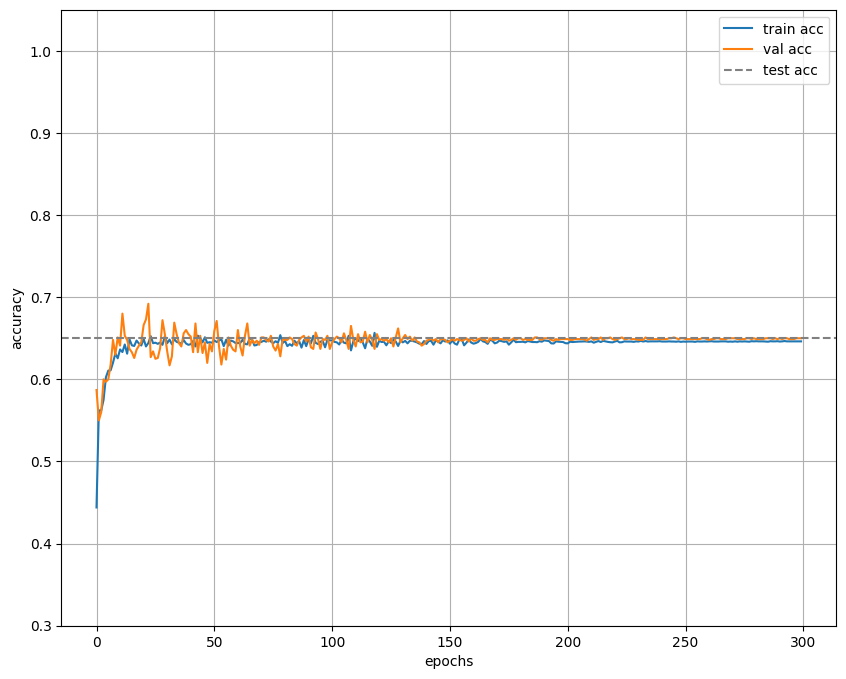

In [30]:
trainer = Trainer(linear_classifier, train_loader, val_loader, test_loader)
train_accuracies, val_accuracies = trainer.train()
test_accuracies = trainer.test()
trainer.plot_training_accuracies(train_accuracies, val_accuracies, test_accuracies)


Based on the accuracy plot provided, answer the following questions about the training process and the model's behavior. Carefully observe the changes in accuracy and how it evolves over time.

---

> **Assignment 8**
>
> Why does the accuracy plateau around **65%** and not increase higher?
>
> **Hint:** Consider the complexity of the decision boundaries required by the Yin Yang dataset.
>
> <details>
>
> <summary>Solution</summary>
>
> The accuracy is limited because we are using a **linear classifier**, which can only learn linear decision boundaries. The Yin Yang dataset, however, requires a **non-linear decision boundary** to separate the three classes effectively. A linear model cannot capture the complexity of the dataset.





> **Assignment 9**
>
> We trained the model for **300 epochs**. Would it have been sufficient to train for fewer epochs? Justify your answer. **Hint:** Check how the training loss and validation accuracy change over time.
>
> <details>
>
> <summary>Solution</summary>
>
> Yes, fewer epochs would likely be sufficient. The training loss and validation accuracy **stabilize after around 50 epochs**, indicating that the model has already converged. Training beyond this point does not significantly improve the accuracy and may only lead to longer training times.



> **Assignment 10**
>
> The accuracy plot shows more fluctuations at the beginning of training compared to the end. Why is this the case? **Hint:** Consider how the learning rate changes during training.
>
> <details>
>
> <summary>Solution</summary>
>
> The fluctuations are more pronounced at the beginning because the **learning rate** is initially higher. The learning rate scheduler reduces the learning rate as training progresses, resulting in **smaller weight updates**. This makes the model's adjustments more stable towards the end of training.






> **Assignment 11**
>
> If you had to select the "best model," which one would you choose? Why? >
> **Hint:** Look at the validation accuracy over time.
>
> <details>
>
> <summary>Solution</summary>
>
> The "best model" is the one with the **highest validation accuracy**, typically reached after around **40 epochs**. Selecting the model based on the highest validation accuracy helps ensure better generalization to unseen data, as it indicates that the model performs well not only on the training set but also on the validation set.





> **Assignment 12**
>
> Think about the decision boundaries that the model might have learned. How could they look like? Describe how the model might classify the three classes.
>
> **Hint:** Consider the complexity of the Yin Yang dataset and the linear nature of the classifier.
>
> <details>
>
> <summary>Solution</summary>
>
> Since the classifier is linear, the decision boundaries are **straight lines**. This means the model will likely split the input space into three regions using linear separations. However, given the complexity of the Yin Yang dataset, this approach will not capture the true shape of the classes, leading to many misclassifications. A plot below shows the learned decision boundaries for a better visual understanding.

---

### Decision Boundaries

After answering the questions, visualize the decision boundaries by executing the cells below. Does it correspond to your expectation?

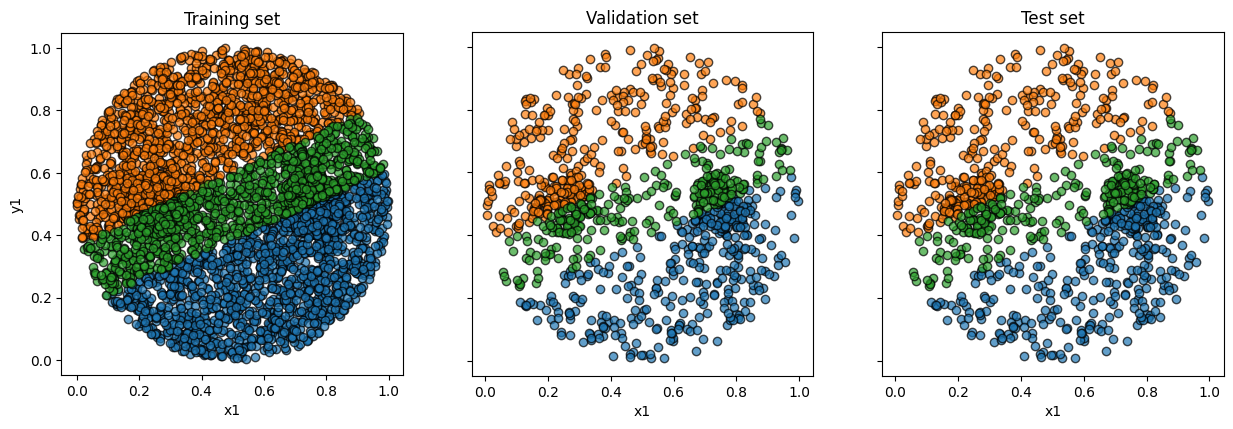

In [31]:
trainer.visualize_predictions()

---

## 4.1: Training the Model with Frozen Layer <a name="4.1"></a>

We train the model with the frozen layer and plot the accuracy.

Epoch 25/300 - Training accuracy: 0.8332 - Validation accuracy: 0.8490
Epoch 50/300 - Training accuracy: 0.8510 - Validation accuracy: 0.8400
Epoch 75/300 - Training accuracy: 0.8624 - Validation accuracy: 0.8650
Epoch 100/300 - Training accuracy: 0.8722 - Validation accuracy: 0.8780
Epoch 125/300 - Training accuracy: 0.8832 - Validation accuracy: 0.8610
Epoch 150/300 - Training accuracy: 0.8802 - Validation accuracy: 0.8960
Epoch 175/300 - Training accuracy: 0.8876 - Validation accuracy: 0.8730
Epoch 200/300 - Training accuracy: 0.8966 - Validation accuracy: 0.8810
Epoch 225/300 - Training accuracy: 0.8956 - Validation accuracy: 0.8960
Epoch 250/300 - Training accuracy: 0.8980 - Validation accuracy: 0.8920
Epoch 275/300 - Training accuracy: 0.9016 - Validation accuracy: 0.8860
Epoch 300/300 - Training accuracy: 0.9020 - Validation accuracy: 0.8890
Test accuracy: 0.8890


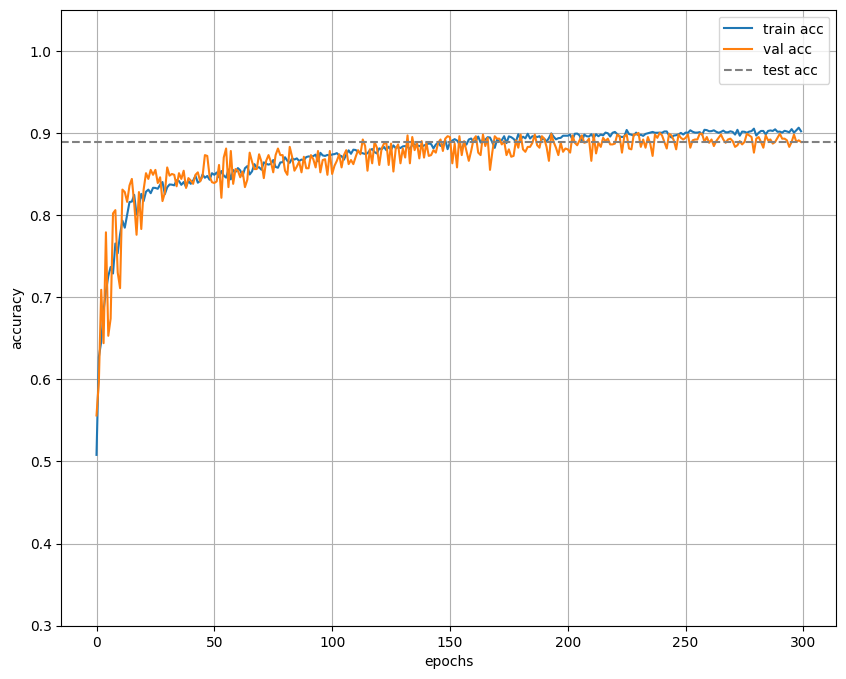

In [32]:
trainer = Trainer(ann_frozen, train_loader, val_loader, test_loader)
train_accuracies, val_accuracies = trainer.train()
test_accuracies = trainer.test()
trainer.plot_training_accuracies(train_accuracies, val_accuracies, test_accuracies)

Based on the accuracy plot provided, answer the following questions about the training process and the model's behavior.

---

> **Assignment 13**
>
> Compare the accuracy plot of the model with the frozen layer to the linear classifier. What differences do you observe? Consider the accuracy that the model achieved and how long it took (number of epochs) to reach it.
>
> <details>
>
> <summary>Solution</summary>
>
> Doing the linear classification in a higher-dimensional space allows to achieve a higher accuracy (as it enables non-linear decision boundaries). The model with the frozen layer achieves an accuracy of around 86% after 250 epochs, while the linear classifier reaches its highest accuracy of about 68% after 40 epochs.

---


### Visualize the Decision Boundaries

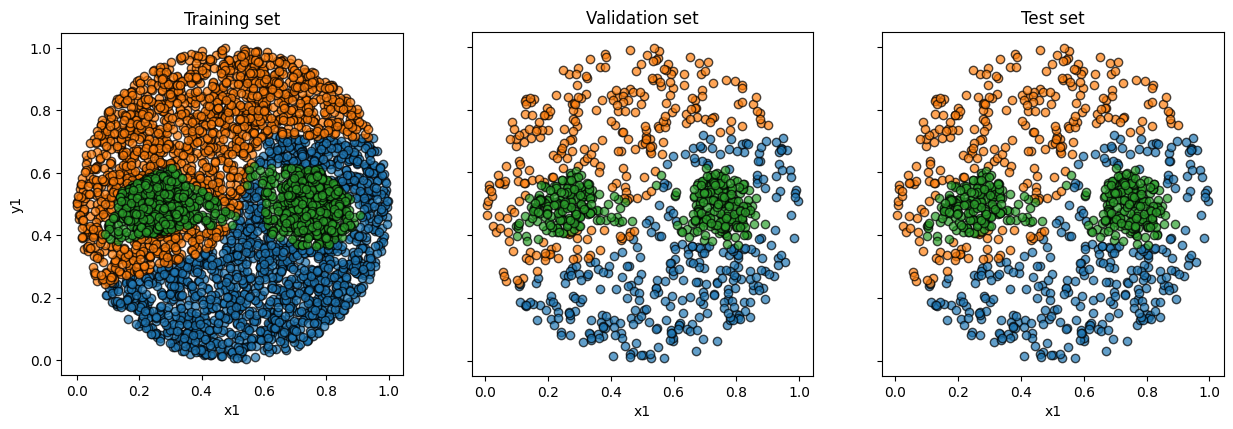

In [33]:
trainer.visualize_predictions()

---

> **Assignment 14**
>
> We trained a linear classifier. Why is the decision boundary non-linear?
>
> <details>
>
> <summary>Solution</summary>
>
> Since we first map the features in a higher dimensional space and do the linear classifier in that space, the decision boundaries in the input space are non-linear.

---


## 4.2: Training the Model with Hidden Layer <a name="4.2"></a>

Epoch 25/300 - Training accuracy: 0.8376 - Validation accuracy: 0.8380
Epoch 50/300 - Training accuracy: 0.9590 - Validation accuracy: 0.9640
Epoch 75/300 - Training accuracy: 0.9598 - Validation accuracy: 0.9730
Epoch 100/300 - Training accuracy: 0.9672 - Validation accuracy: 0.9840
Epoch 125/300 - Training accuracy: 0.9742 - Validation accuracy: 0.9830
Epoch 150/300 - Training accuracy: 0.9736 - Validation accuracy: 0.9800
Epoch 175/300 - Training accuracy: 0.9748 - Validation accuracy: 0.9800
Epoch 200/300 - Training accuracy: 0.9782 - Validation accuracy: 0.9850
Epoch 225/300 - Training accuracy: 0.9792 - Validation accuracy: 0.9810
Epoch 250/300 - Training accuracy: 0.9788 - Validation accuracy: 0.9840
Epoch 275/300 - Training accuracy: 0.9792 - Validation accuracy: 0.9820
Epoch 300/300 - Training accuracy: 0.9792 - Validation accuracy: 0.9840
Test accuracy: 0.9840


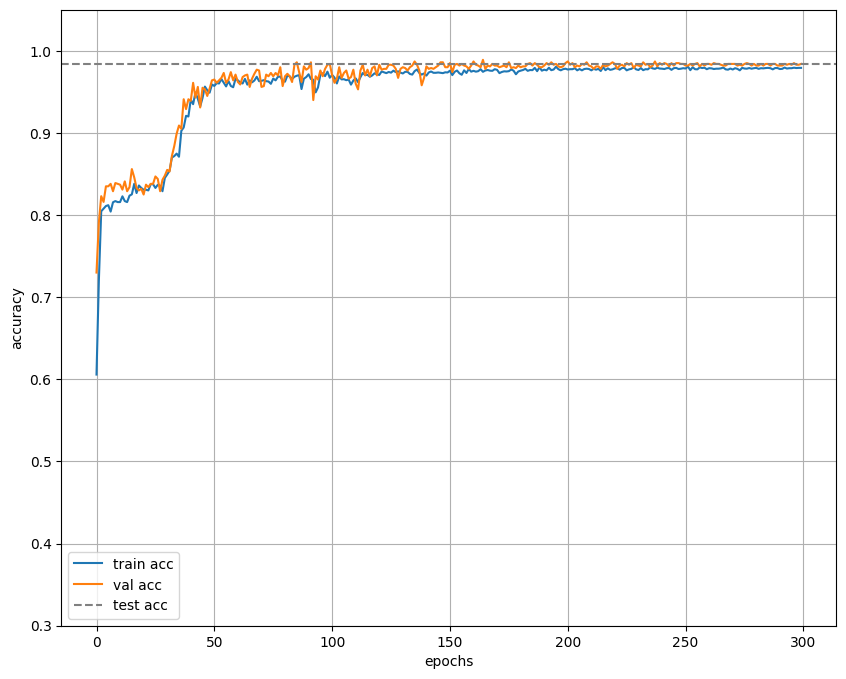

In [34]:
trainer = Trainer(net, train_loader, val_loader, test_loader)
train_accuracies, val_accuracies = trainer.train()
test_accuracies = trainer.test()
trainer.plot_training_accuracies(train_accuracies, val_accuracies, test_accuracies)


---

> **Assignment 15**
>
> Compare the accuracy plot of the model with the hidden layer to the one with frozen layer. What differences do you observe? Consider the accuracy that the model achieved and how long it took (number of epochs) to reach it.
>
> <details>
>
> <summary>Solution</summary>
>
> The model with the frozen layer achieves an accuracy of around 86% after 250 epochs, while the model with one hidden layer achieves an accuracy of 98% after 100 epochs. The model with the hidden layer reaches a higher accuracy in fewer epochs.

---

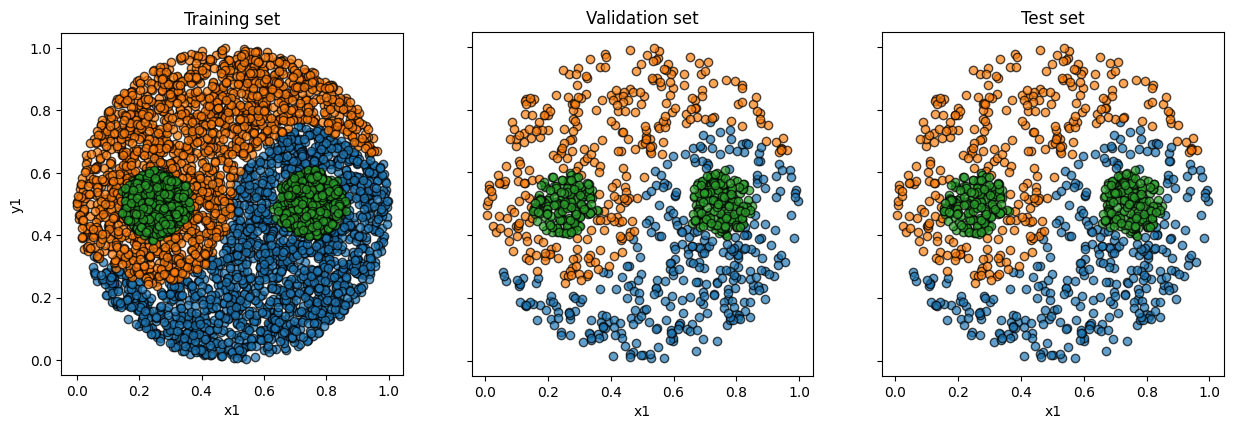

In [35]:
trainer.visualize_predictions()

---

# 5: Spiking Neural Networks (SNNs) <a name="5"></a>

For this part of the lab, we adapted some text and code from Dr. Friedemann Zenke (https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb).

In [36]:
from utils_ex13.snn_data import *
from utils_ex13.snn import *

---

## 5.1: Input Preparation <a name="5.1"></a>

Unlike Artificial Neural Networks (ANNs), Spiking Neural Networks (SNNs) operate on discrete events called **spikes** instead of continuous feature values. This means the input data used for training and evaluation must be transformed into a spiking representation.

To prepare the Yin Yang dataset for the SNN, each feature value is converted into a spike pattern. The spike train represents the frequency of spikes over a fixed time window. Here’s how the transformation works:

**Poisson Distribution Sampling**: For each feature of a sample, we generate spikes by sampling from a **Poisson distribution**. The frequency of spikes corresponds to the magnitude of the feature value:
   - Higher feature values result in **more frequent spikes**.
   - Lower feature values result in **less frequent spikes**.

Each sample consists of $4$ features: **x**, **y**, **1-x**, and **1-y** for which we sample spikes. We use a time-windows of $200$ms and generate with a frequency between $1$Hz (low feature values) and $100$Hz (high feature values).

##### **Why Spikes?**
Spiking Neural Networks aim to mimic biological neural networks, where information is encoded as spike timings. This makes SNNs fundamentally different from traditional ANNs, which operate on continuous values. The spike-based representation allows SNNs to leverage temporal dynamics for processing information. This is not only biologically more plausible but also more efficient when executed on corresponding hardware.

Unfortunately, we will run this lab on a "normal" computer platform which does not support such spike-based processing. Therefore, we cannot benefit from the advantages such as reduced power-consumption of SNNs in this lab.

### Print the First Sample

In [37]:
train_loader, val_loader, test_loader = get_dataloader()

sample = train_loader.dataset[0]
print("Data shapes:", sample[0].shape)
print("Data unique values:", np.unique(sample[0]))
print("Label:", sample[1])

Data shapes: (200, 4)
Data unique values: [0. 1.]
Label: 2


---

**Assignment 16**
>
> Above, we plotted the shape, unique values, and label of the first sample. What do these outputs represent?
>
> <details>
>
> <summary>Solution</summary>
>
> The shape of the data is (200, 4). The first dimension corresponds to the time window of the sample, and the second dimension to the $4$ features we have. Thus, for each feature, we have $200$ values, each representing the state of a feature neuron at a specific time step.
>
> The unique values represent the value one feature neuron can have. This is either $0$ or $1$, meaning that we have binary inputs.
>
> The label represents the class of the sample, which can be Yin, Yang, or Two Circles.


---


## 5.2: Plot a Data Sample <a name="5.2"></a>

In [38]:
plot_sample_slider(train_loader.dataset)

---

> **Assignment 17**
>
> Above, we visualize the spikes and the corresponding location on the plot with the data samples. Try to understand how adjusting the x-y position changes these plots. What do you observe? Is it possible to obtain consistently an accuracy of 100% on this task?
>
> <details>
>
> <summary>Solution</summary>
>
> Close at the decision boundary, there exist samples with highly similar features (only slight deviation in x or y). Since the value of these features is used as a spike sample probability, it can happen that a sample looks like from class A even though it is from class B. Having longer time windows could reduce this effect, as the spike count would be higher, allowing for a better distinction. However, this would also increase the computational effort.

---


## 5.3: Mathematical Model <a name="5.3"></a>

The spiking neural network (SNN) we use is based on a feedforward architecture with leaky integrate-and-fire (LIF) neurons and current-based synapses. This model is closely related to a discrete-time recurrent neural network (RNN) but includes spiking dynamics. Below, we describe the underlying mathematical principles. While this section provides important context, it is not required for the exam.

<details>
<summary>Mathematical Model (not exam relevant)</summary>

*Text is taken from https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb*


The LIF neuron is a widely used model in computational neuroscience and can be expressed as a time-continuous differential equation:

$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$

where $U_i$ is the membrane potential of neuron $i$ in layer $l$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron. A neuron emits a spike when its membrane potential $U_i$ exceeds the firing threshold $\vartheta$.  After spiking, the membrane potential resets to the resting state. The spike train of a neuron is expressed as:

$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$

where $\delta(t)$ is the Dirac delta function and $t_j^k$ are the spike times of neuron $i$. Spikes propagate to downstream neurons, generating post-synaptic currents:

$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t)$$

where $W_{ij}$ are synaptic weights, and $\tau_\mathrm{syn}$ is the synaptic decay time constant.

In discrete time, with natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$, the model becomes:

$$I_i^{(l)}[t+1] = \alpha I_i^{(l)}[t] + \sum_j W_{ij} S_j^{(l-1)}[t]$$

$$U_i^{(l)}[t+1] = \beta U_i^{(l)}[t] + I_i^{(l)}[t] - S_i^{(l)}[t]$$

where:
- $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$
- $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$
- $S_i^{(l)}(t)=\Theta(U_i^{(l)}[t]-\vartheta)$
    
</details>

---


## 5.4: Training the Spiking Neural Network <a name="5.4"></a>

We define a network similar to the one used above for the ANN-part. We have one layer mapping the $4$ input features to $30$ hidden neurons. The weights for this mapping are learned using backpropagation of error. The SNN consists of:

- **Hidden layer**: Maps 4 input features to 30 hidden neurons. It consists of LIF neurons with synaptic connections.
- **Output layer**: Aggregates spiking activity to classify into one of 3 classes.

Synaptic weights ($W$) between neurons are trainable parameters and can be excitatory (positive) or inhibitory (negative). Spikes arriving at a neuron increase its membrane potential until the firing threshold is reached. When a spike occurs:

1. The membrane potential resets.
2. A spike is emitted to downstream neurons.

#### Neuron Dynamics

Each neuron maintains two states:

1. **Synaptic current ($I$)**: Captures input from presynaptic spikes.
2. **Membrane potential ($U$)**: Represents the neuron's internal state.

The dynamics are updated iteratively over 200 time steps for each input sample:

- **Synaptic Current**

$$
I[t+1] = \alpha \cdot I[t] + W \cdot X[t]
$$

where $X[t]$ represents the input spikes at time $t$.

- **Membrane Potential**

$$
U[t+1] = \beta \cdot U[t] + I[t] - S[t]
$$

where $S[t]$ is the step function determining spikes (1 if the neuron spikes, 0 otherwise).

#### Output Aggregation

Over 200 time steps, the output layer collects spiking activity. Instead of averaging, the network uses the maximum spike value across time steps for classification. This ensures that the network responds strongly to prominent spiking patterns, providing robustness to temporal variations.

$$
y_\mathrm{agg} = \max_{t \in [1,200]} S_\mathrm{out}[t]
$$

#### Loss Function

The output is passed through a log-softmax activation to compute class probabilities. The network is trained using Negative Log Likelihood Loss (NLLLoss):

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \log P(y_i | X_i)
$$

where $P(y_i | X_i)$ is the predicted probability of class $y_i$ given input $X_i$.

#### Optimization

Similar to the ANN exercise, the network is optimized using **AdamW** optimizer and a **learning rate scheduler** that reduces the learning rate if training plateaus, helping the network converge smoothly.


####  Summary of Training Workflow

1. **Input Processing:**
  - Each input sample is processed over 200 time steps.
  - Synaptic current and membrane potential are updated iteratively.
2. **Spike Generation:**
  - Membrane potential exceeding the threshold produces spikes.
3. **Output Aggregation:**
  - The maximum spike value across time steps is used for classification.
4. **Loss Calculation:**
  - Log-softmax is applied to the aggregated output, and NLLLoss is computed.
5. **Weight Update:**
  - Gradients are computed using backpropagation, and weights are updated using AdamW.


By iterating over multiple epochs, the network learns to classify input samples by adjusting weights to minimize the loss.

In [39]:
network_layout = {
    'n_inputs': 4,
    'layer_sizes': [30, 3],
}

net_step_fn = SNN(network_layout, spike_fn=step_fn)

We now train the network. We only use 100 epochs (and not 300 as for the ANN) as training takes longer. Feel free to increase the number of epochs.

Epoch 5/100 - Training accuracy: 0.4856 - Validation accuracy: 0.5010
Epoch 10/100 - Training accuracy: 0.5762 - Validation accuracy: 0.5840
Epoch 15/100 - Training accuracy: 0.5980 - Validation accuracy: 0.5920
Epoch 20/100 - Training accuracy: 0.5888 - Validation accuracy: 0.5820
Epoch 25/100 - Training accuracy: 0.5898 - Validation accuracy: 0.5910
Epoch 30/100 - Training accuracy: 0.5958 - Validation accuracy: 0.6020
Epoch 35/100 - Training accuracy: 0.5996 - Validation accuracy: 0.6030
Epoch 40/100 - Training accuracy: 0.6100 - Validation accuracy: 0.6130
Epoch 45/100 - Training accuracy: 0.6224 - Validation accuracy: 0.6220
Epoch 50/100 - Training accuracy: 0.6286 - Validation accuracy: 0.6260
Epoch 55/100 - Training accuracy: 0.6296 - Validation accuracy: 0.6290
Epoch 60/100 - Training accuracy: 0.6416 - Validation accuracy: 0.6460
Epoch 65/100 - Training accuracy: 0.6490 - Validation accuracy: 0.6470
Epoch 70/100 - Training accuracy: 0.6454 - Validation accuracy: 0.6380
Epoch 7

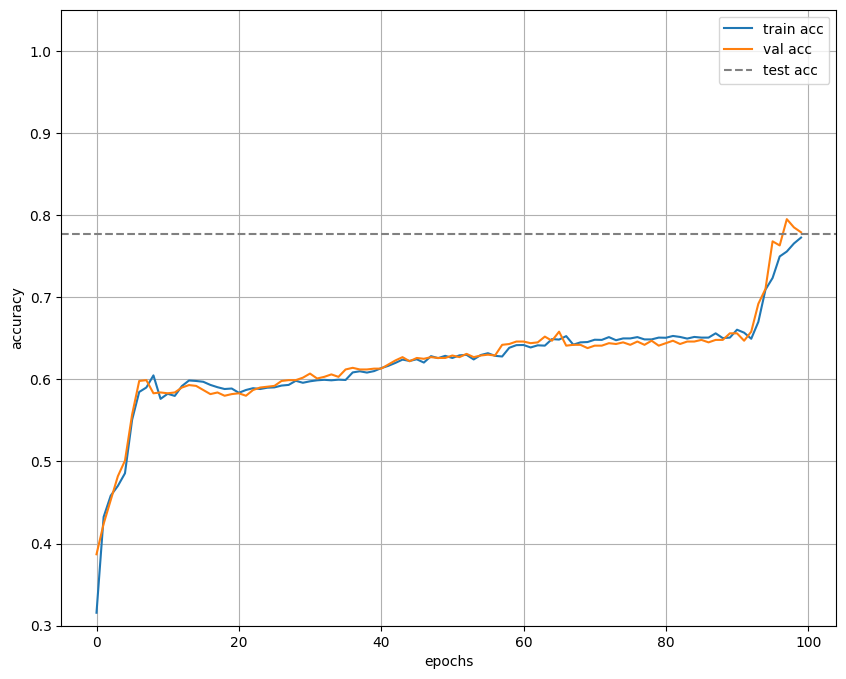

In [40]:
trainer = Trainer(net_step_fn, train_loader, val_loader, test_loader, n_epochs=100)
train_accuracies, val_accuracies = trainer.train()
test_accuracies = trainer.test()
trainer.plot_training_accuracies(train_accuracies, val_accuracies, test_accuracies)

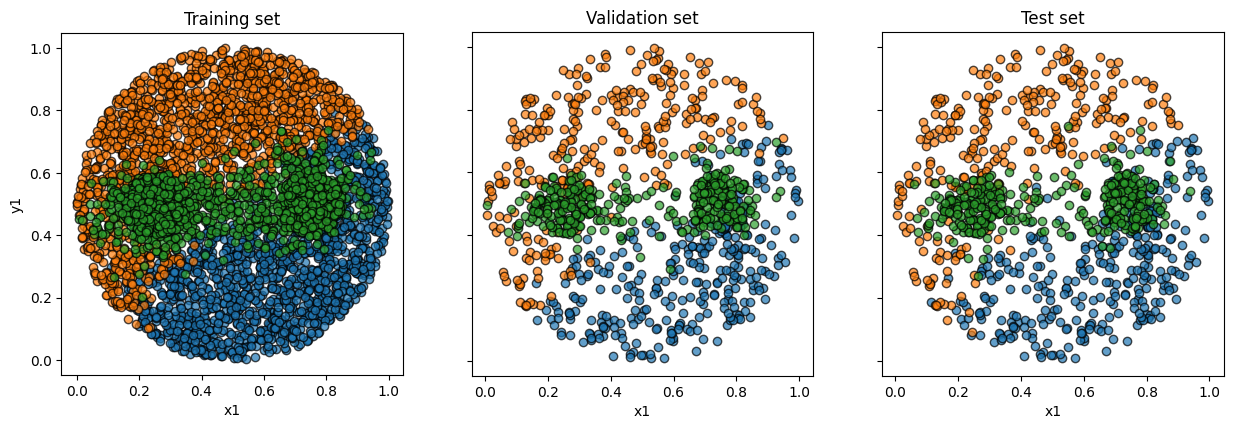

In [41]:
trainer.visualize_predictions()

---

> **Assignment 18**
>
> The accuracy curve does not increase smoothly and levels of quite fast around 70% - This is not how a good learning curve should look like. Why could this happen?
>
> **Hint**: Consider that we use backpropagation of error. What re the gradients of the step function?
>
> <details>
>
> <summary>Solution</summary>
>
> The reason is that the non-linearity of the hidden units have zero derivatives everywhere except at threshold crossings, where they become infinite. In practice that means that weight updates in the hidden layer vanish and the weights remain unmodified. Thus, we have a similar model to the ANN with the first layer frozen!

---



## 5.5: Surrogate Gradient Descent <a name="5.5"></a>

In the previous section, we encountered a fundamental challenge: the **step function** used in spiking neurons has a **zero gradient** almost everywhere. This characteristic makes backpropagation ineffective, as gradients cannot flow backward to earlier layers, particularly the first layer. Consequently, the network cannot learn effectively.

Most conventional artificial neural networks (ANNs) avoid this issue by employing activation functions with non-zero derivatives, such as:

- **Sigmoid** or **tanh**: These functions were commonly used in early neural network research.
- **ReLU (Rectified Linear Unit)**: The standard activation function in modern ANNs, which provides a sparse but non-zero gradient.

The crucial feature of these functions is that they allow gradients to propagate through the network, enabling efficient learning. In contrast, the binary step function provides no gradients during backpropagation, effectively halting learning in the upstream layers.

#### Surrogate Gradient Approach

What can we do if we want to retain the **binary non-linearity** of spiking neurons while still training the network effectively? A promising solution is to use **surrogate gradients**. The core idea is simple but powerful:

- Instead of changing the activation function itself, we only replace its gradient during the backpropagation step.

This approach enables us to compute meaningful parameter updates, even when the forward pass uses the step function. Instead of directly using the gradient of the step function (which is zero almost everywhere), we approximate it with the gradient of a smooth function. A commonly used surrogate is the fast sigmoid function, defined as:

$$
\sigma(x) = \frac{1}{1 + e^{-\beta x}}
$$

where $\beta$ is a scaling factor that controls the steepness of the sigmoid. The surrogate gradient is derived from the partial derivative of this function:

$$
\frac{\partial \sigma(x)}{\partial x} = \beta \cdot \sigma(x) \cdot (1 - \sigma(x))
$$


This gradient provides non-zero support across a range of input values, enabling the learning process to proceed. By rescaling this gradient appropriately, we can ensure that it behaves similarly to the binary step function in practice.

**Benefits of Surrogate Gradients**
- Preserves the Step Function in Forward Pass: The spiking neuron retains its binary behavior for spiking dynamics and inference.
- Allows Gradients to Flow in Backward Pass: The surrogate gradient ensures that the upstream layers, including the first layer, receive meaningful updates during backpropagation.
- Boosts Training Performance: By addressing the vanishing gradient problem, surrogate gradients significantly improve the trainability of spiking neural networks.


We visualize this concept below, where the surrogate gradient approximates the step function's derivative:

<img src="https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex13/figures/surrgrad.png"  width="400">

By using surrogate gradients, we effectively combine the advantages of spiking dynamics in the forward pass with efficient learning in the backward pass. This technique has been widely adopted in spiking neural networks and is a cornerstone for training such models effectively.

Let's train the network using surrogate gradients and observe the learning behavior.

Epoch 5/100 - Training accuracy: 0.7506 - Validation accuracy: 0.7750
Epoch 10/100 - Training accuracy: 0.8022 - Validation accuracy: 0.8120
Epoch 15/100 - Training accuracy: 0.8290 - Validation accuracy: 0.8400
Epoch 20/100 - Training accuracy: 0.8384 - Validation accuracy: 0.8490
Epoch 25/100 - Training accuracy: 0.8500 - Validation accuracy: 0.8530
Epoch 30/100 - Training accuracy: 0.8596 - Validation accuracy: 0.8480
Epoch 35/100 - Training accuracy: 0.8600 - Validation accuracy: 0.8640
Epoch 40/100 - Training accuracy: 0.8694 - Validation accuracy: 0.8690
Epoch 45/100 - Training accuracy: 0.8794 - Validation accuracy: 0.8740
Epoch 50/100 - Training accuracy: 0.8920 - Validation accuracy: 0.8730
Epoch 55/100 - Training accuracy: 0.8934 - Validation accuracy: 0.8940
Epoch 60/100 - Training accuracy: 0.8748 - Validation accuracy: 0.8880
Epoch 65/100 - Training accuracy: 0.8808 - Validation accuracy: 0.8890
Epoch 70/100 - Training accuracy: 0.8902 - Validation accuracy: 0.8920
Epoch 7

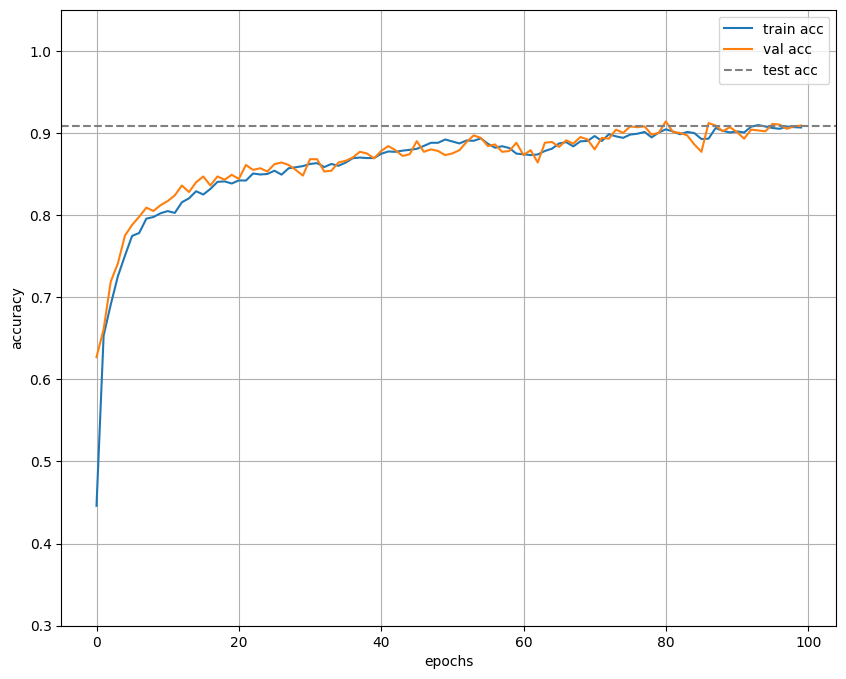

In [42]:
net_step_fn = SNN(network_layout, spike_fn=surrogate_fn)
trainer = Trainer(net_step_fn, train_loader, val_loader, test_loader, n_epochs=100)
train_accuracies, val_accuracies = trainer.train()
test_accuracies = trainer.test()
trainer.plot_training_accuracies(train_accuracies, val_accuracies, test_accuracies)

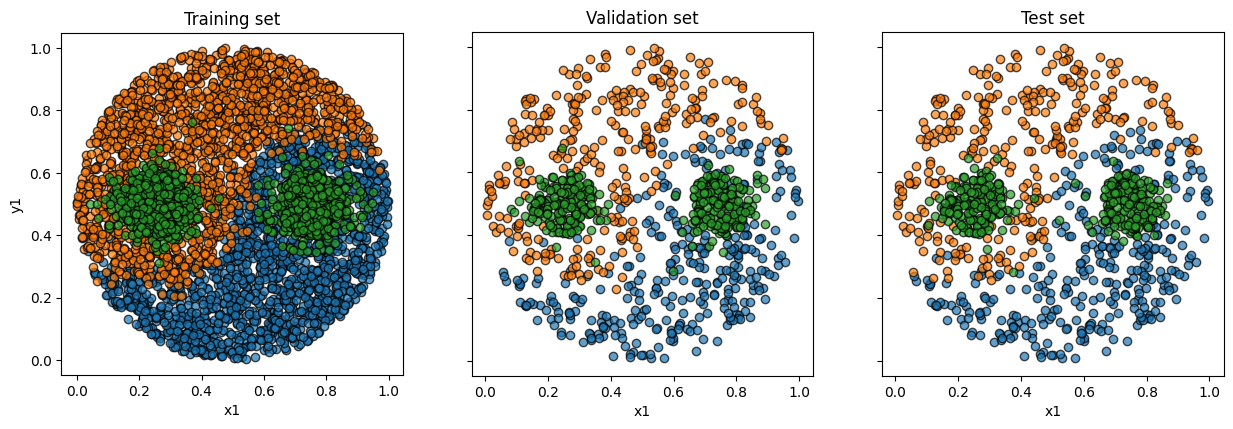

In [43]:
trainer.visualize_predictions()

---

> **Assignment 19**
>
> Consider the training progress of ANNs and SNNs. What are the differences? Which method trained faster? Which method achieved the better accuracy?
>
> **Hint:** We trained the SNN for only 100 epochs. If we train it for 300 epochs, we achieve about the same performance as with the ANN.
>
> <details>
>
> <summary>Solution</summary>
>
> The ANN trained much faster and achieved a higher accuracy of around 98% after 100 epochs. The SNN, on the other hand, requires more time to reach a similar accuracy of around 98% after 100 epochs. Also one epoch using ANN is faster than one epoch using SNN, as for the SNN, we need to loop over the 200 timesteps per sample.






> **Assignment 20**
>
> Reflect on your answers from assignment 19: In which settings would the SNN be superior? **Hint:** Think about the computation platform (hardware) and the task (static data that is transformed into spikes). For which setting is this better suited?
>
> <details>
>
> <summary>Solution</summary>
>
> SNNs are superior in settings where energy efficiency, temporal data processing, or biologically realistic models are essential:
>
> 1. Energy Efficiency: On neuromorphic hardware (e.g., Loihi, SpiNNaker), SNNs are highly energy-efficient due to their sparse, event-driven computation.
> 2. Temporal Data: SNNs excel at tasks like speech recognition or event detection, where timing information is crucial.
> 3. Biological Plausibility: SNNs are ideal for brain-inspired applications or neuroscience research.
> 4. Spike-Based Input: For static data transformed into spikes, SNNs handle such representations efficiently, especially in real-time systems.
>
> In summary, SNNs are better suited for low-power, sequential data tasks or biologically inspired computing.


---

# End of this exercise session